# ML.Net - Samples - SpamDetection

# Spam Detection for Text Messages

| ML.NET version | API type          | Status                        | App Type    | Data type | Scenario            | ML Task                   | Algorithms                  |
|----------------|-------------------|-------------------------------|-------------|-----------|---------------------|---------------------------|-----------------------------|
| v1.5           | Dynamic API | Might need to update project structure to match template | Jupyter Notebbok | .tsv files | Spam detection | Two-class classification | Averaged Perceptron (linear learner) |

In this sample, you'll see how to use [ML.NET](https://www.microsoft.com/net/learn/apps/machine-learning-and-ai/ml-dotnet) to predict whether a text message is spam. In the world of machine learning, this type of prediction is known as **binary classification**.

## Problem

Our goal here is to predict whether a text message is spam (an irrelevant/unwanted message). We will use the [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from UCI, which contains close to 6000 messages that have been classified as being "spam" or "ham" (not spam). We will use this dataset to train a model that can take in new message and predict whether they are spam or not.

This is an example of binary classification, as we are classifying the text messages into one of two categories.


## Solution

To solve this problem, first we will build an estimator to define the ML pipeline we want to use. Then we will train this estimator on existing data, evaluate how good it is, and lastly we'll consume the model to predict whether a few examples messages are spam.

![Build -> Train -> Evaluate -> Consume](../shared_content/modelpipeline.png)
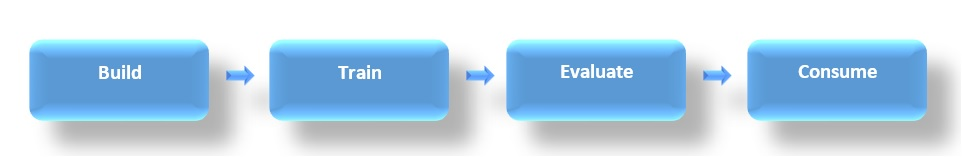

### 1. Build Model

To build the model we will:

* Define how to read the spam dataset that will be downloaded from https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. 

* Apply several data transformations:

    * Convert the label ("spam" or "ham") to a boolean ("true" represents spam) so we can use it with a binary classifier. 
    * Featurize the text message into a numeric vector so a machine learning trainer can use it

* Add a trainer (such as `StochasticDualCoordinateAscent`).

In [16]:
// ML.NET Nuget packages installation
#r "nuget:Microsoft.ML" 

## Using C# Class

In [17]:
using System;
using System.IO;
using System.IO.Compression;
using System.Linq;
using System.Net;
using Microsoft.ML;
using Microsoft.ML.Data;
using System.Collections.Generic;
using static Microsoft.ML.TrainCatalogBase;
using static Microsoft.ML.DataOperationsCatalog;
using System.Diagnostics;

## Declare data-classes for input data and predictions

In [18]:
public class SpamInput
{
    [LoadColumn(0)]
    public string Label { get; set; }
    [LoadColumn(1)]
    public string Message { get; set; }
}

public class SpamPrediction
{
    [ColumnName("PredictedLabel")]
    public string isSpam { get; set; }
}

### Constants

In [19]:
private static string AppPath => Path.GetDirectoryName(Environment.GetCommandLineArgs()[0]);
private static string DataDirectoryPath => Path.Combine(AppPath, "..", "..", "..", "Data", "spamfolder");
private static string TrainDataPath => Path.Combine(AppPath, "..", "..", "..", "Data", "spamfolder", "SMSSpamCollection");

### ClassifyMessage

In [20]:
public static void ClassifyMessage(PredictionEngine<SpamInput, SpamPrediction> predictor, string message)
{
    var input = new SpamInput { Message = message };
    var prediction = predictor.Predict(input);

    Console.WriteLine("The message '{0}' is {1}", input.Message, prediction.isSpam == "spam" ? "spam" : "not spam");
}

### ConsoleHelper

In [25]:
public static class ConsoleHelper
{
    public static void PrintPrediction(string prediction)
    {
        Console.WriteLine($"*************************************************");
        Console.WriteLine($"Predicted : {prediction}");
        Console.WriteLine($"*************************************************");
    }

    public static void PrintRegressionPredictionVersusObserved(string predictionCount, string observedCount)
    {
        Console.WriteLine($"-------------------------------------------------");
        Console.WriteLine($"Predicted : {predictionCount}");
        Console.WriteLine($"Actual:     {observedCount}");
        Console.WriteLine($"-------------------------------------------------");
    }

    public static void PrintRegressionMetrics(string name, RegressionMetrics metrics)
    {
        Console.WriteLine($"*************************************************");
        Console.WriteLine($"*       Metrics for {name} regression model      ");
        Console.WriteLine($"*------------------------------------------------");
        Console.WriteLine($"*       LossFn:        {metrics.LossFunction:0.##}");
        Console.WriteLine($"*       R2 Score:      {metrics.RSquared:0.##}");
        Console.WriteLine($"*       Absolute loss: {metrics.MeanAbsoluteError:#.##}");
        Console.WriteLine($"*       Squared loss:  {metrics.MeanSquaredError:#.##}");
        Console.WriteLine($"*       RMS loss:      {metrics.RootMeanSquaredError:#.##}");
        Console.WriteLine($"*************************************************");
    }

    public static void PrintBinaryClassificationMetrics(string name, CalibratedBinaryClassificationMetrics metrics)
    {
        Console.WriteLine($"************************************************************");
        Console.WriteLine($"*       Metrics for {name} binary classification model      ");
        Console.WriteLine($"*-----------------------------------------------------------");
        Console.WriteLine($"*       Accuracy: {metrics.Accuracy:P2}");
        Console.WriteLine($"*       Area Under Curve:      {metrics.AreaUnderRocCurve:P2}");
        Console.WriteLine($"*       Area under Precision recall Curve:  {metrics.AreaUnderPrecisionRecallCurve:P2}");
        Console.WriteLine($"*       F1Score:  {metrics.F1Score:P2}");
        Console.WriteLine($"*       LogLoss:  {metrics.LogLoss:#.##}");
        Console.WriteLine($"*       LogLossReduction:  {metrics.LogLossReduction:#.##}");
        Console.WriteLine($"*       PositivePrecision:  {metrics.PositivePrecision:#.##}");
        Console.WriteLine($"*       PositiveRecall:  {metrics.PositiveRecall:#.##}");
        Console.WriteLine($"*       NegativePrecision:  {metrics.NegativePrecision:#.##}");
        Console.WriteLine($"*       NegativeRecall:  {metrics.NegativeRecall:P2}");
        Console.WriteLine($"************************************************************");
    }

    public static void PrintMultiClassClassificationMetrics(string name, MulticlassClassificationMetrics metrics)
    {
        Console.WriteLine($"************************************************************");
        Console.WriteLine($"*    Metrics for {name} multi-class classification model   ");
        Console.WriteLine($"*-----------------------------------------------------------");
        Console.WriteLine($"    AccuracyMacro = {metrics.MacroAccuracy:0.####}, a value between 0 and 1, the closer to 1, the better");
        Console.WriteLine($"    AccuracyMicro = {metrics.MicroAccuracy:0.####}, a value between 0 and 1, the closer to 1, the better");
        Console.WriteLine($"    LogLoss = {metrics.LogLoss:0.####}, the closer to 0, the better");
        Console.WriteLine($"    LogLoss for class 1 = {metrics.PerClassLogLoss[0]:0.####}, the closer to 0, the better");
        Console.WriteLine($"    LogLoss for class 2 = {metrics.PerClassLogLoss[1]:0.####}, the closer to 0, the better");
        Console.WriteLine($"    LogLoss for class 3 = {metrics.PerClassLogLoss[2]:0.####}, the closer to 0, the better");
        Console.WriteLine($"************************************************************");
    }
    
    public static void PrintRegressionFoldsAverageMetrics(string algorithmName, IReadOnlyList<CrossValidationResult<RegressionMetrics>> crossValidationResults)
    {
        var L1 = crossValidationResults.Select(r => r.Metrics.MeanAbsoluteError);
        var L2 = crossValidationResults.Select(r => r.Metrics.MeanSquaredError);
        var RMS = crossValidationResults.Select(r => r.Metrics.RootMeanSquaredError);
        var lossFunction = crossValidationResults.Select(r => r.Metrics.LossFunction);
        var R2 = crossValidationResults.Select(r => r.Metrics.RSquared);

        Console.WriteLine($"*************************************************************************************************************");
        Console.WriteLine($"*       Metrics for {algorithmName} Regression model      ");
        Console.WriteLine($"*------------------------------------------------------------------------------------------------------------");
        Console.WriteLine($"*       Average L1 Loss:    {L1.Average():0.###} ");
        Console.WriteLine($"*       Average L2 Loss:    {L2.Average():0.###}  ");
        Console.WriteLine($"*       Average RMS:          {RMS.Average():0.###}  ");
        Console.WriteLine($"*       Average Loss Function: {lossFunction.Average():0.###}  ");
        Console.WriteLine($"*       Average R-squared: {R2.Average():0.###}  ");
        Console.WriteLine($"*************************************************************************************************************");
    }
    
    public static void PrintMulticlassClassificationFoldsAverageMetrics(
                                     string algorithmName,
                                   IReadOnlyList<CrossValidationResult<MulticlassClassificationMetrics>> crossValResults
                                                                       )
    {
        var metricsInMultipleFolds = crossValResults.Select(r => r.Metrics);

        var microAccuracyValues = metricsInMultipleFolds.Select(m => m.MicroAccuracy);
        var microAccuracyAverage = microAccuracyValues.Average();
        var microAccuraciesStdDeviation = CalculateStandardDeviation(microAccuracyValues);
        var microAccuraciesConfidenceInterval95 = CalculateConfidenceInterval95(microAccuracyValues);

        var macroAccuracyValues = metricsInMultipleFolds.Select(m => m.MacroAccuracy);
        var macroAccuracyAverage = macroAccuracyValues.Average();
        var macroAccuraciesStdDeviation = CalculateStandardDeviation(macroAccuracyValues);
        var macroAccuraciesConfidenceInterval95 = CalculateConfidenceInterval95(macroAccuracyValues);

        var logLossValues = metricsInMultipleFolds.Select(m => m.LogLoss);
        var logLossAverage = logLossValues.Average();
        var logLossStdDeviation = CalculateStandardDeviation(logLossValues);
        var logLossConfidenceInterval95 = CalculateConfidenceInterval95(logLossValues);

        var logLossReductionValues = metricsInMultipleFolds.Select(m => m.LogLossReduction);
        var logLossReductionAverage = logLossReductionValues.Average();
        var logLossReductionStdDeviation = CalculateStandardDeviation(logLossReductionValues);
        var logLossReductionConfidenceInterval95 = CalculateConfidenceInterval95(logLossReductionValues);

        Console.WriteLine($"*************************************************************************************************************");
        Console.WriteLine($"*       Metrics for {algorithmName} Multi-class Classification model      ");
        Console.WriteLine($"*------------------------------------------------------------------------------------------------------------");
        Console.WriteLine($"*       Average MicroAccuracy:    {microAccuracyAverage:0.###}  - Standard deviation: ({microAccuraciesStdDeviation:#.###})  - Confidence Interval 95%: ({microAccuraciesConfidenceInterval95:#.###})");
        Console.WriteLine($"*       Average MacroAccuracy:    {macroAccuracyAverage:0.###}  - Standard deviation: ({macroAccuraciesStdDeviation:#.###})  - Confidence Interval 95%: ({macroAccuraciesConfidenceInterval95:#.###})");
        Console.WriteLine($"*       Average LogLoss:          {logLossAverage:#.###}  - Standard deviation: ({logLossStdDeviation:#.###})  - Confidence Interval 95%: ({logLossConfidenceInterval95:#.###})");
        Console.WriteLine($"*       Average LogLossReduction: {logLossReductionAverage:#.###}  - Standard deviation: ({logLossReductionStdDeviation:#.###})  - Confidence Interval 95%: ({logLossReductionConfidenceInterval95:#.###})");
        Console.WriteLine($"*************************************************************************************************************");
    }    

    public static double CalculateStandardDeviation (IEnumerable<double> values)
    {
        double average = values.Average();
        double sumOfSquaresOfDifferences = values.Select(val => (val - average) * (val - average)).Sum();
        double standardDeviation = Math.Sqrt(sumOfSquaresOfDifferences / (values.Count()-1));
        return standardDeviation;
    }

    public static double CalculateConfidenceInterval95(IEnumerable<double> values)
    {
        double confidenceInterval95 = 1.96 * CalculateStandardDeviation(values) / Math.Sqrt((values.Count()-1));
        return confidenceInterval95;
    }

    public static void PrintClusteringMetrics(string name, ClusteringMetrics metrics)
    {
        Console.WriteLine($"*************************************************");
        Console.WriteLine($"*       Metrics for {name} clustering model      ");
        Console.WriteLine($"*------------------------------------------------");
        Console.WriteLine($"*       Average Distance: {metrics.AverageDistance}");
        Console.WriteLine($"*       Davies Bouldin Index is: {metrics.DaviesBouldinIndex}");
        Console.WriteLine($"*************************************************");
    }    
}

## Evaluate

In [22]:
   // Download the dataset if it doesn't exist.
if (!File.Exists(TrainDataPath))
{
    using (var client = new WebClient())
    {
        //The code below will download a dataset from a third-party, UCI (link), and may be governed by separate third-party terms. 
        //By proceeding, you agree to those separate terms.
        client.DownloadFile("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip", "spam.zip");
    }

    ZipFile.ExtractToDirectory("spam.zip", DataDirectoryPath);
}

// Set up the MLContext, which is a catalog of components in ML.NET.
MLContext mlContext = new MLContext();

// Specify the schema for spam data and read it into DataView.
var data = mlContext.Data.LoadFromTextFile<SpamInput>(path: TrainDataPath, hasHeader: true, separatorChar: '\t');

// Create the estimator which converts the text label to boolean, featurizes the text, and adds a linear trainer.
// Data process configuration with pipeline data transformations 
var dataProcessPipeline = mlContext.Transforms.Conversion.MapValueToKey("Label", "Label")
                          .Append(mlContext.Transforms.Text.FeaturizeText("FeaturesText", new Microsoft.ML.Transforms.Text.TextFeaturizingEstimator.Options
                          {
                              WordFeatureExtractor = new Microsoft.ML.Transforms.Text.WordBagEstimator.Options { NgramLength = 2, UseAllLengths = true },
                              CharFeatureExtractor = new Microsoft.ML.Transforms.Text.WordBagEstimator.Options { NgramLength = 3, UseAllLengths = false },
                          }, "Message"))
                          .Append(mlContext.Transforms.CopyColumns("Features", "FeaturesText"))
                          .Append(mlContext.Transforms.NormalizeLpNorm("Features", "Features"))
                          .AppendCacheCheckpoint(mlContext);

### 2. Evaluate model

For this dataset, we will use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to evaluate our model. This will partition the data into 5 'folds', train 5 models (on each combination of 4 folds), and test them on the fold that wasn't used in training.

```CSharp
var crossValidationResults = mlContext.MulticlassClassification.CrossValidate(data: data, estimator: trainingPipeLine, numberOfFolds: 5);
```

Note that usually we evaluate a model after training it. However, cross-validation includes the model training part so we don't need to do `Fit()` first. However, we will later train the model on the full dataset to take advantage of the additional data.

In [23]:
// Set the training algorithm 
var trainer = mlContext.MulticlassClassification.Trainers.OneVersusAll(mlContext.BinaryClassification.Trainers.AveragedPerceptron(labelColumnName: "Label", numberOfIterations: 10, featureColumnName: "Features"), labelColumnName: "Label")
                          .Append(mlContext.Transforms.Conversion.MapKeyToValue("PredictedLabel", "PredictedLabel"));
var trainingPipeLine = dataProcessPipeline.Append(trainer);

// Evaluate the model using cross-validation.
// Cross-validation splits our dataset into 'folds', trains a model on some folds and 
// evaluates it on the remaining fold. We are using 5 folds so we get back 5 sets of scores.
// Let's compute the average AUC, which should be between 0.5 and 1 (higher is better).
Console.WriteLine("=============== Cross-validating to get model's accuracy metrics ===============");
var crossValidationResults = mlContext.MulticlassClassification.CrossValidate(data: data, estimator: trainingPipeLine, numberOfFolds: 5);
ConsoleHelper.PrintMulticlassClassificationFoldsAverageMetrics(trainer.ToString(), crossValidationResults);

### 3. Train model
To train the model we will call the estimator's `Fit()` method while providing the full training data.

```CSharp
var model = trainingPipeLine.Fit(data);

In [23]:
// Now let's train a model on the full dataset to help us get better results
var model = trainingPipeLine.Fit(data);

=============== Cross-validating to get model's accuracy metrics ===============
*************************************************************************************************************
*       Metrics for Microsoft.ML.Data.EstimatorChain`1[Microsoft.ML.Transforms.KeyToValueMappingTransformer] Multi-class Classification model      
*------------------------------------------------------------------------------------------------------------
*       Average MicroAccuracy:    0,987  - Standard deviation: (,004)  - Confidence Interval 95%: (,004)
*       Average MacroAccuracy:    0,967  - Standard deviation: (,009)  - Confidence Interval 95%: (,009)
*       Average LogLoss:          ,049  - Standard deviation: (,015)  - Confidence Interval 95%: (,015)
*       Average LogLossReduction: ,875  - Standard deviation: (,038)  - Confidence Interval 95%: (,037)
*************************************************************************************************************


### 4. Consume model

After the model is trained, you can use the `Predict()` API to predict whether new text is spam. 

In [24]:
//Create a PredictionFunction from our model 
var predictor = mlContext.Model.CreatePredictionEngine<SpamInput, SpamPrediction>(model);

Console.WriteLine("=============== Predictions for below data===============");
// Test a few examples
ClassifyMessage(predictor, "That's a great idea. It should work.");
ClassifyMessage(predictor, "free medicine winner! congratulations");
ClassifyMessage(predictor, "Yes we should meet over the weekend!");
ClassifyMessage(predictor, "you win pills and free entry vouchers");

Console.WriteLine("=============== End of process =============== ");
Console.ReadLine();

=============== Predictions for below data===============
The message 'That's a great idea. It should work.' is not spam
The message 'free medicine winner! congratulations' is spam
The message 'Yes we should meet over the weekend!' is not spam
The message 'you win pills and free entry vouchers' is spam
=============== End of process =============== 
